In [1]:
%%capture
!pip install pandas
!pip install tensorflow
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install nltk
!pip install unidecode

from google.colab import files
uploaded = files.upload()

# Bibliotecas

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re
import unidecode
import warnings
import seaborn as sns
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

sw = set(stopwords.words('english'))
es = EarlyStopping(patience = 3)
np.random.seed(23)
sns.set_style('dark')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [3]:
def remove_username(text):
  text = re.sub(r'\@[^\s]+', ' ', text)
  return text

def only_letters(text):
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  return text

def remove_link(text):
  text = re.sub(r'www\.?[^\s]+', ' ', text)
  return text

def remove_hyperlink(text):
  text = re.sub(r'\<.?\>', ' ', text)
  return text

def remove_accent(text):
  text = unidecode.unidecode(text)
  return text

def adjustment_text(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

def remove_stopwords(text):
  text = [word for word in text.split() if word not in sw]
  text = ' '.join(text)
  return text

def remove_spam(text):
  text = re.sub(r'\&amp', ' ', text)
  text = re.sub(r'\&lt', ' ', text)
  text = re.sub(r'\&gt', ' ', text)
  text = re.sub(r'\#follow|\#followme|\#like|\#f4f|\#photooftheday', ' ', text)
  return text

def remove_slangs(text):
  text = re.sub(r' b4 ', ' before ', text)
  text = re.sub(r' 2b ', ' to be ', text)
  text = re.sub(r' 2morrow ', ' tomorrow ', text)
  text = re.sub(r' rn ', ' right now ', text)
  text = re.sub(r' brb ', ' be right back ', text)
  text = re.sub(r' mb ', ' my bad ', text)
  text = re.sub(r' luv ', ' love ', text)
  text = re.sub(r' b ', ' be ', text)
  text = re.sub(r' r ', ' are ', text)
  text = re.sub(r' u ', ' you ', text)
  text = re.sub(r' y ', ' why ', text)
  text = re.sub(r' ur ', ' your ', text)
  text = re.sub(r' hbd ', ' happy birthday ', text)
  text = re.sub(r' bday ', ' birthday ', text)
  text = re.sub(r' bihday ', ' birthday ', text)
  text = re.sub(r' omg ', ' oh my god ', text)
  text = re.sub(r' lol ', ' laughing out loud ', text)
  return text

def remove_abbreviations(text):
  text = re.sub(r" can't ", " can not ", text)
  text = re.sub(r" i'm ", " i am ", text)
  text = re.sub(r" i'll ", " i will ", text)
  text = re.sub(r" i'd ", " i would ", text)
  text = re.sub(r" i've ", " i have ", text)
  text = re.sub(r" ain't ", " am not ", text)
  text = re.sub(r" haven't ", " have not ", text)
  text = re.sub(r" hasn't ", " has not ", text)
  text = re.sub(r" can't ", " can not ", text)
  text = re.sub(r" won't ", " will not ", text)
  text = re.sub(r" you're ", " you are ", text)
  text = re.sub(r" we're ", " we are ", text)
  text = re.sub(r" they're ", " they are ", text)
  text = re.sub(r" he's ", " he is ", text)
  text = re.sub(r" she's ", " she is ", text)
  text = re.sub(r" it's ", " it is ", text)
  text = re.sub(r" don't ", " do not ", text)
  text = re.sub(r" doesn't ", " does not ", text)
  text = re.sub(r" wouldn't ", " would not ", text)
  text = re.sub(r" couldn't ", " could not ", text)
  text = re.sub(r" shouldn't ", " should not ", text)
  text = re.sub(r" no-one ", " noone ", text)
  return text

def remove_one_len_word(text):
  text = re.sub(r'\b[a-z]\b', ' ', text)
  return text

def preprocessing(data):
  data['cleaned_tweet'] = data['tweet'].apply(str)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: x.lower())
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_hyperlink)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_spam)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_link)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_username)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_accent)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_abbreviations)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(only_letters)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_slangs)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_stopwords)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(remove_one_len_word)
  data['cleaned_tweet'] = data['cleaned_tweet'].apply(adjustment_text)
  return data

# Modelos

## Modelo 1

In [4]:
def modelo1():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Modelo 2

In [5]:
def modelo2():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 64,
                   kernel_size = 5,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Modelo 3

In [ ]:
def modelo3():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 64,
                   kernel_size = 5,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 128,
                   kernel_size = 7,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Modelo 4

In [7]:
def modelo4():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 64,
                   kernel_size = 5,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 64,
                  activation = 'relu'))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Modelo 5

In [6]:
def modelo5():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 64,
                  activation = 'relu'))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Modelo 6

In [ ]:
def modelo6():
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size,
                      output_dim = embedding_dim,
                      input_length = length_size))
  model.add(Conv1D(filters = 32,
                   kernel_size = 3,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 64,
                   kernel_size = 5,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = 128,
                   kernel_size = 7,
                   padding = 'same',
                   activation = 'relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dropout(rate = 0.2))
  model.add(Dense(units = 64,
                  activation = 'relu'))
  model.add(Dense(units = 1,
                  activation = 'sigmoid'))
  
  #model.summary()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  history_model = model.fit(x = X_train,
                            y = y_train,
                            validation_data = (X_validation, y_validation),
                            batch_size = 100,
                            epochs = 20,
                            callbacks = [es])
  
  predicted = (model.predict(X_validation) > 0.5).astype("int32")
  score = f1_score(predicted, y_validation, average='weighted')
  return model, score

## Predict

In [8]:
def predict(modelo, nome, use_preprocessing=False):
  test = pd.read_csv('Data/test.csv')

  if use_preprocessing:
    test = preprocessing(test)
    test['tokenized'] = tokenizer.texts_to_sequences(test['cleaned_tweet'])
  else:
    test['tokenized'] = tokenizer.texts_to_sequences(test['tweet'])

  X_test = pad_sequences(sequences = test['tokenized'],
                         maxlen = length_size,
                         padding = 'post')

  predicted = (model.predict(X_test) > 0.5).astype("int32")
  prediction = pd.DataFrame()
  prediction['id'] = test['id']
  prediction['label'] = predicted
  prediction.to_csv('teste1_v2.csv', index=False)

# Main

In [9]:
use_preprocessing = False
test_size = 0.25
length_size = 15
embedding_dim = 300

In [10]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [11]:
data = preprocessing(data)
data = data.dropna()
data.head(15)

,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...
2,0,bihday your majesty,birthday majesty
3,0,#model i love u take with u all the time in ...,model love take time urd ddddd
4,0,factsguide: society now #motivation,factsguide society motivation
5,0,[2/2] huge fan fare and big talking before the...,huge fan fare big talking leave chaos pay disp...
6,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannya
7,0,the next school year is the year for exams.ð...,next school year year exams think school exams...
8,0,we won!!! love the land!!! #allin #cavs #champ...,love land allin cavs champions cleveland cleve...
9,0,@user @user welcome here ! i'm it's so #gr...,welcome gr


In [12]:
data.shape

(31962, 3)

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_tweet'])

In [14]:
data['tokenized'] = tokenizer.texts_to_sequences(data['cleaned_tweet'])
data.head()

,label,tweet,cleaned_tweet,tokenized
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...,"[21, 15328, 2498, 6207, 158, 7606, 338]"
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,"[89, 5284, 2351, 324, 513, 1358, 7607, 9879, 7..."
2,0,bihday your majesty,birthday majesty,"[15, 3131]"
3,0,#model i love u take with u all the time in ...,model love take time urd ddddd,"[68, 1, 22, 6, 85, 53]"
4,0,factsguide: society now #motivation,factsguide society motivation,"[2672, 1223, 202]"


In [15]:
data['tweet_len'] = data['cleaned_tweet'].apply(lambda x: len(x.split()))

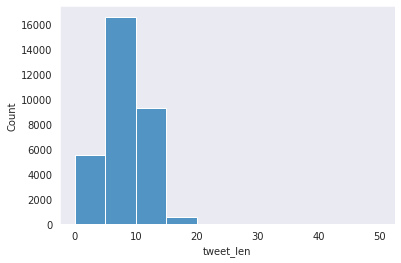

In [16]:
sns.histplot(data=data, x='tweet_len', bins=10)

In [17]:
print(data['tweet_len'].mean(), max(data['tweet_len']))

7.760934860146424 50


In [18]:
vocab_size = len(tokenizer.word_index) + 1

In [19]:
X = pad_sequences(sequences = data['tokenized'],
                  maxlen = length_size,
                  padding = 'post')

y = data['label']

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y, 
                                                                test_size = test_size,
                                                                random_state = 23)

In [21]:
modelos = ['modelo1', 'modelo2', 'modelo3', 'modelo4', 'modelo5', 'modelo6']
resultados = pd.DataFrame()
scores = []

for modelo in modelos:

  if modelo == 'modelo1':
    m, score = modelo1()

  elif modelo == 'modelo2':
    m, score = modelo2()
    
  elif modelo == 'modelo3':
    m, score = modelo3()
    
  elif modelo == 'modelo4':
    m, score = modelo4()
    
  elif modelo == 'modelo5':
    m, score = modelo5()
    
  elif modelo == 'modelo6':
    m, score = modelo6()
  
  scores.append(score)
  predict(m, modelo, use_preprocessing)

Epoch 1/20
240/240 [==============================] - 52s 147ms/step - loss: 0.2947 - accuracy: 0.9294 - val_loss: 0.1459 - val_accuracy: 0.9463
Epoch 2/20
240/240 [==============================] - 34s 144ms/step - loss: 0.0673 - accuracy: 0.9760 - val_loss: 0.1258 - val_accuracy: 0.9592
Epoch 3/20
240/240 [==============================] - 34s 144ms/step - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.1488 - val_accuracy: 0.9590
Epoch 4/20
240/240 [==============================] - 34s 144ms/step - loss: 0.0068 - accuracy: 0.9983 - val_loss: 0.1667 - val_accuracy: 0.9565
Epoch 5/20
240/240 [==============================] - 34s 143ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.1776 - val_accuracy: 0.9588


(<keras.engine.sequential.Sequential at 0x7f48d354cc90>, 0.9608861880750866)

In [ ]:
resultados['modelos'] = modelos
resultados['f1_score'] = score
resultados['preprocessamento'] = use_preprocessing
resultados.head()